In [2]:
from pandas import Series, DataFrame
import pandas as pd
import nltk
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [4]:
train = pd.read_csv("../Train_rev1.csv")
train[:3]

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk


In [6]:
train_sample = train.sample(1000).reset_index() # Creates sample of 1000 job descriptions

# Part A (Basic Text Mining)

In [7]:
# Tokenize all job descriptions
train_sample['tokenized_strip'] = train_sample.apply(lambda row: row['FullDescription'].decode('utf-8').strip(),axis=1)
train_sample['tokenized'] = train_sample.apply(lambda row: nltk.word_tokenize(row['tokenized_strip']),axis=1)

In [8]:
# Get part of speech tags for each token in each description
train_sample['PoS'] = train_sample.apply(lambda row: nltk.pos_tag(row['tokenized']), axis=1)

## A1. Top 5 Parts of Speech in Corpus

In [9]:
# Create list of all tokens in corpus
all_tokens = []
for i in range(len(train_sample['tokenized'])):
    all_tokens = all_tokens + train_sample['tokenized'][i]

In [10]:
# Get part of speech tags for all tokens in corpus
all_PoS = nltk.pos_tag(all_tokens)

In [11]:
tokens, PoS = zip(*all_PoS) # Unzip all_PoS to separate list of tokens from list of parts of speech
PoS_freq = nltk.FreqDist(PoS) # Frequency of each part of speech
top5_PoS = PoS_freq.most_common()[:5] # 5 most frequent parts of speech in corpus
top5_PoS

[('NN', 43936), ('NNP', 32850), ('IN', 25253), ('JJ', 21365), ('DT', 19698)]

The 5 most common parts of speech in this corpus along with their respective frequencies are:
1. Noun, singular or mass: 46,389
2. Proper noun, singular: 33,742
3. Preposition or Subordinating Conjunction: 25,724
4. Adjective: 22,063
5. Determiner: 20,188

## A2. Zipf's Law, 100 Most Common Words

In [12]:
from nltk.tokenize import RegexpTokenizer
word_tokenizer = RegexpTokenizer(r'\w+')

# Get list of words without punctuation for each job description
train_sample['tokenized_words'] = train_sample.apply(lambda row: word_tokenizer.tokenize(row['tokenized_strip']),axis=1)

# Create list of words from all job descriptions
all_words = []
for i in range(len(train_sample['tokenized_words'])):
    all_words = all_words + train_sample['tokenized_words'][i]

# Make all words lowercase
words_lower = []
for word in all_words:
    words_lower.append(word.lower())

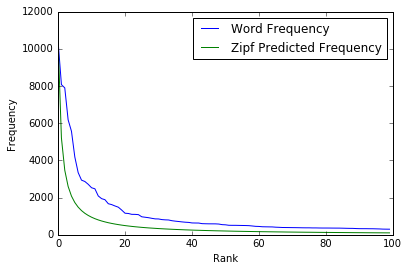

In [13]:
# Find 100 most frequent words
words_freq = nltk.FreqDist(words_lower)
top100_words = words_freq.most_common()[:100]

# Get values for expected frequency of top 100 words using Zipf's Law
max_freq = top100_words[0][1]
counter = 1
zipf = []
while len(zipf) < 100:
    zipf.append(max_freq/counter)
    counter += 1

# Plot actual frequencies and Zipf frequencies
plot([b for (a,b) in top100_words], label = 'Word Frequency') # Blue
plot(zipf, label = 'Zipf Predicted Frequency') # Green
legend(loc='best')
xlabel('Rank')
ylabel('Frequency')

## A3. Top 10 Words after Stemming and Removing Stop Words. 

In [14]:
from nltk.corpus import stopwords
no_stops_words = [word for word in words_lower if word not in stopwords.words('english')]

In [27]:
from nltk.stem.porter import PorterStemmer
PS = PorterStemmer()

stem_words = []

for word in no_stops_words:
    stem_word = PS.stem(word)
    stem_words.append(stem_word)

In [28]:
# Find 10 most frequent words
words_freq_no_stops = nltk.FreqDist(stem_words)
top10_words = words_freq_no_stops.most_common()[:10]

top10_words

[(u'work', 2141),
 (u'manag', 2049),
 (u'experi', 1642),
 (u'role', 1246),
 (u'team', 1226),
 (u'busi', 1213),
 (u'client', 1206),
 (u'develop', 1150),
 (u'requir', 1018),
 (u'servic', 1017)]

# Part B (predict salary from job description)

In [5]:
jobs_b = train[['FullDescription', 'SalaryNormalized']]
jobs_b_sample = jobs_b.sample(5000)

In [6]:
descriptions = []
pay = []

for index, value in jobs_b_sample.iterrows():
    descriptions.append(value['FullDescription'])
    pay.append(value['SalaryNormalized'])
    
perc_75 = np.percentile(pay, 75)
content = zip(descriptions, pay)

In [7]:
def find_pay_bin(pay):
    return pay >= perc_75

### Sample Naive Bayes: Length of Description

In [8]:
def description_length(desc):
    return {'description_length': len(desc)}

In [9]:
feature_sets = [(description_length(desc), find_pay_bin(pay)) for (desc, pay) in content]

train_set = feature_sets[2500:]
test_set = feature_sets[:2500]

classifier = nltk.NaiveBayesClassifier.train(train_set)

nltk.classify.accuracy(classifier, test_set)

0.6996

### Sample Naive Bayes: Number of Words in Description

In [10]:
def description_word_length(desc):
    return {'description_word_length': len(desc.split())}

In [11]:
feature_sets = [(description_word_length(desc), find_pay_bin(pay)) for (desc, pay) in content]

train_set = feature_sets[2500:]
test_set = feature_sets[:2500]

classifier = nltk.NaiveBayesClassifier.train(train_set)

nltk.classify.accuracy(classifier, test_set)

0.71960000000000002